# Tema 3: Modelos básicos de Aprendizaje de Máquina y Validación cruzada
## Objetivo del Ciclo 3 ID:
El objetivo del Ciclo 3 ID es conocer sobre los modelos de Regresión de Ridge, Lasso y Elastic Net, así como los Árboles de Decisión y Bosques Aleatorios, y de esta manera, conjuntando con los conocimientos sobre K Nearest Neighbors, poder seleccionar el modelo que nos proporcione predicciones más precisas

### 3.1 Importación de librerías
* Nuestro primer paso consiste en importar todas las librerías que utilizaremos en este código, las cuales se enlistan a continuación:
    * numpy y pandas (para el manejo de la base de datos de las solicitudes de las bicicletas)
    * matplotlib (para generar gráficos que nos permitan visualizar la información compartida)
    * Sklearn (para la generación de los diferentes modelos de KNN Vecinos, utilizando sus siguientes dos módulos:)
        * KNeighborsRegressor (crea modelos de regresión KNN, lo que nos permitirá generar predicciones de la demanda de bicicletas)
        * mean_squared_error (métrica de medición de los errores de la predicción, en contraste con los datos reales)
        * Pipeline
        * LabelEncoder,OrdinalEncoder,LabelBinarizer y OneHotEncoder (para transformación numérica de variables categóricas)
        * StandardScaler y MinMaxScaler (para normalización/estandarización de variables)
        * PowerTransformer (para cambios a distribución normal de variables)
        * ColumnTransformer (para combinación de procesos de transformación a variables)
        * VarianceThreshold  (para identifiación de variables relevantes para el modelo)
    * pickle (para exportar un modelo)

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder,OrdinalEncoder,LabelBinarizer,OneHotEncoder)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, r_regression
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import (LinearRegression,Ridge)
from sklearn.ensemble import RandomForestRegressor
import pickle

### 3.2 Lectura de la base de datos
Leemos la base de datos proporcionada, utilizando la librería de pandas.
Dentro de la función de read_csv hemos definido el parámetro de "encoding" como "latin1" para que pueda leer caracteres especiales, ya sea en los nombres de las variables y/o en los valores de estas

In [4]:
#Leemos la base de datos proporcionada
bd_bikepro=pd.read_csv(r"C:\Users\cjcamper.AFIRME\Documents\Certificacion AI Core\Primer_reto\Recursos\Data\SeoulBikeData.csv",encoding='latin1')

Hacemos un head para visualizar las primeras filas de nuestra base

In [5]:
bd_bikepro.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

### 3.3 Modificación de nombres y valores de variables

#### Ajustes a realizar a los nombres de nuestras columnas:
Realizamos un "one-liner" (código en una sola línea) para este bucle de iteración sobre las columnas y darles un mejor formato, partiendo por los siguientes pasos:

1. Primero vamos a iterar sobre cada columna del dataset, la cual llamaremos **"col"**
2. Luego vamos a convertir cada columna en minúsculas con la función **lower**
3. Al ver los nombres de variables como **"Visibility"**, cuyos nombres están separados del primer paréntesis (en donde tenemos sus respectivas escalas), sustitumos ese paréntesis por un paréntesis sin espacio con la función **replace**
4. Después realizamos un **split** entre los paréntesis, que nos separará los nombres de las columnas de los paréntesis (ya sin espacio) , para solo quedarnos con el nombre de la variable sin su escala
5. En el siguiente paso separamos cada palabra del nombre de la variable, nuevamente usando la función **split**, ahora separando por espacios
6. Finalmente, con el método **join**, juntaremos con un guion bajo como delimitador cada una de las palabras


In [6]:
#las nuevas variables se guardarán en el elemento "new_columns"
new_columns=["_".join(col.lower().replace(' (','(').split('(')[0].split(' ')) for col in bd_bikepro.columns]

In [7]:
#ahora asignamos el elemento "new_columns" a nuestra base de datos
bd_bikepro.columns=new_columns

### Modificación de formato para los valores de columnas
La variable "date" juega un rol fundamental ya que nos permite ordenar nuestros datos, por lo que necesitamos que esté en el formato correcto de fecha

In [8]:
#convertimos en formato fecha la variable de "date"
bd_bikepro['date'] = pd.to_datetime(bd_bikepro['date'], format='%d/%m/%Y')

In [9]:
#Seleccionaremos nuestras columnas del clima descartando todas aquellas variables que no estén relacionadas al clima
weather_cols=[col for col in bd_bikepro.columns if col not in ['date','rented_bike_count','hour','seasons','holiday','functioning_day','dew_point_temperature']]
target_col = ['rented_bike_count']

### 3.4 Generación de nuevas variables
Generaremos una variable que nos indique el mes de la fecha, así como otra variable que señale si el día de demanda de bicicletas fue en fin de semana

In [10]:
#empezamos generando la variable del mes del año
bd_bikepro['month_day']=bd_bikepro['date'].dt.month.astype('category')

In [11]:
#generamos la bandera que nos indique si el día es fin de semana
bd_bikepro['flag_day_weekend'] = np.where(bd_bikepro['date'].dt.weekday> 4,'Yes','No')

In [12]:
#generamos una variable para saber el día de la semana
bd_bikepro['weekday']=bd_bikepro['date'].dt.weekday.astype('category')

In [13]:
#generamos una variable que indica qué parte del día según la hora
bd_bikepro['part_day']=np.where(bd_bikepro['hour'].isin(list(np.arange(0,6))),'madrugada',np.where(bd_bikepro['hour'].isin(list(np.arange(7,12))),'mañana',np.where(bd_bikepro['hour'].isin(list(np.arange(13,18))),'tarde','noche')))

In [14]:
#convertimos las variables de "seasons" y "hour" en variables categóricas
bd_bikepro['seasons']=bd_bikepro['seasons'].astype('category')
bd_bikepro['hour']=bd_bikepro['hour'].astype('category')

In [15]:
#generamos una variable que nos indique si el siguiente día será día inhábil (cuenta fines de semana y días festivo)
from datetime import timedelta
bd_bikepro.sort_values(by=['date','hour'],inplace=True)
bd_bikepro['flag_next_day_no_work']=np.where((pd.to_datetime(bd_bikepro['date']+timedelta(days=1)).isin(bd_bikepro[bd_bikepro['holiday']==0]['date'].drop_duplicates(keep='first').tolist())) | (bd_bikepro['weekday'].isin([6,7])),1,0)

### 3.5 Ordenamiento de datos
Tal como se comentó, ordenaremos nuestra información por fecha y hora. Este paso es muy importante ya que necesitamos considerar toda la tendencia histórica que ha habido en la demanda de bicicletas, ya que este dato será vital para la construcción del modelo y la predicción que nos dará

La función "sort_values", definiendo los campos para ordenación, nos ayudará a ordenar nuestros datos, tomando el paramétro "inplace" como **True** para que realiza la ordenación en nuestro dataset

In [16]:
bd_bikepro.sort_values(by=['date','hour'],inplace=True)

### 3.6 Transformación de variables categóricas
Para este paso  vamos a convertir nuestras variables categóricas a numéricas, usando diferentes transformaciones dependiendo de los valores de cada variabe. Las variables categóricas a transformar son:
* seasons
* functioning_day
* holiday
* flag_day_weekend
* month_day

In [17]:
#Las variables "seasons", "month_day", "part_day","hour" y "weekday" serán transformadas por OneHotEncoder
categorical_pipeline = Pipeline([('categorical', OneHotEncoder(handle_unknown='ignore'))])

In [18]:
#nuestras variables "functioning_day","holiday" y "flag_day_weekend" y "flag_next_day_no_work" serán transformadas a binarios, solo que lo haremos directamente desde la base de datos
binary_cols=["functioning_day", "holiday","flag_day_weekend","flag_next_day_no_work"]

In [19]:
#iteraremos en la lista de las variables definidas como binarias, para que una por una sean transformadas a binarias y se vayan incorporando a la base de datos original
lb=LabelBinarizer()
for i in range(len(binary_cols)):
    new_column=pd.DataFrame(lb.fit_transform(bd_bikepro[binary_cols[i]]),columns=binary_cols[i:i+1])
    bd_bikepro.drop(columns=binary_cols[i:i+1],inplace=True)
    bd_bikepro=pd.concat([bd_bikepro,new_column],axis=1)

### 3.7 Cambios en la distribución de las variables

Al hacer un histograma de cada una de las variables numéricas del clima observamos que ninguna sigue una distribución normal, por lo que se tienen que transformar los valores de estas

array([[<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'wind_speed'}>],
       [<AxesSubplot:title={'center':'visibility'}>,
        <AxesSubplot:title={'center':'solar_radiation'}>,
        <AxesSubplot:title={'center':'rainfall'}>],
       [<AxesSubplot:title={'center':'snowfall'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

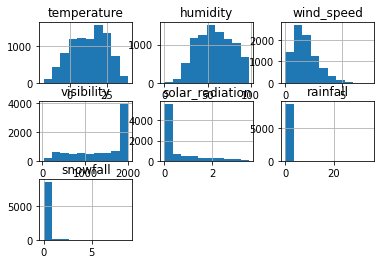

In [18]:
bd_bikepro[weather_cols].hist()

Dos posibles métodos para transformar estas variables son la transformación de Box-Cox y Yeo-Johnson.
Partiendo que la transformación de Box-Cox no permite valores igual o menores a 0, hacemos una agrupación mínima por variables del clima para comprobar lo anterior

In [19]:
bd_bikepro[weather_cols].min()
#se observan que todas las variables cumplen lo anterior, por lo que tenemos que utilizar la transformación de Yeo-Johnson

temperature       -17.8
humidity            0.0
wind_speed          0.0
visibility         27.0
solar_radiation     0.0
rainfall            0.0
snowfall            0.0
dtype: float64

Generamos un pipeline para las variables que presenten una distribución diferente a la normal

In [20]:
transformation_pipeline = Pipeline([('transformation', PowerTransformer(method='yeo-johnson'))])

### 3.8 Normalización/estandarización de variables

Al tener variables con diferentes unidades, es recomendable que los valores tengan una misma magnitud. Dos métodos para lograr esto son la estandarización

In [21]:
#generamos un pipeline para la estandarización de las variables
numerical_pipeline = Pipeline([('standar_scaler', StandardScaler())])

### 3.9 Selección de variables
El objetivo de este pipeline es descartar variables cuya varianza sea muy poca o nula, esto al no tener una influencia en el modelo

In [22]:
selector_pipeline = Pipeline([('selector', VarianceThreshold())])

### 3.10 Selección de variables predictora y variable objetivo
Antes de generar nuestro conjunto de entrenamiento y prueba, es importante definir cuáles variables tomaremos en cuenta para la construcción de nuestro modelo, así como la variable que intentaremos predecir (cantidad de bicicletas rentadas)

Partiremos generando una lista donde contendremos las variables relacionadas al clima, la cual llamaremos "weather_cols"

In [23]:
#Entendiendo que todas nuestras variables participarán en el modelo (con sus respectivas transformaciones), generamos una nueva lista con todas las variables, excluyendo la fecha de la demanda de bicicletas, así como la variable objetivo (rented_bike_count)
all_cols=list(bd_bikepro.columns.difference(['date','rented_bike_count','dew_point_temperature']))

### 3.11 Creación de conjunto de entrenamiento y prueba

Para la ejecución de los modelos de aprendizaje automático es importante generar dos conjuntos, uno de entrenamiento y otro de prueba, ya sea para las variables que predecirán los valores, así como la variable objetivo a predecir, respectivamente

* En el conjunto de **entrenamiento** construiremos nuestro modelo de KNN
* En el conjunto de **prueba** buscamos comparar los resultados que se predijeron contra los resultados reales

La demanda de bicicletas tiene un componente temporal, es decir, la demanda ha sido influida por la hora y día en la que se rentaron las bicicletas, por lo que es importante que nuestros conjuntos de entrenamiento y prueba sigan captando las tendencias mostradas. Debido a lo anterior, generaremos nuestros conjuntos dividiendo el dataset original desde determinado registro

In [24]:
# Datos de entrenamiento
x_train = bd_bikepro.loc[: bd_bikepro.shape[0]-1440,:][all_cols]
y_train = bd_bikepro.loc[: bd_bikepro.shape[0]-1440,:][target_col]

# Datos de test
x_test = bd_bikepro.loc[bd_bikepro.shape[0]-1440+1:,:][all_cols]
y_test = bd_bikepro.loc[bd_bikepro.shape[0]-1440+1:,:][target_col]

### 3.12 Ejecución de los modelos
Usando la función ColumnTransformer realizaremos todas nuestras transformaciones generadas en pasos previas, todas en una misma instancia

In [211]:
days_cols=['seasons','hour','weekday','part_day']
pre_processor = ColumnTransformer([
    ('numerical', numerical_pipeline, weather_cols)    
    ,('categorical', categorical_pipeline, days_cols)
    ,('transformation',transformation_pipeline,weather_cols)
], remainder='passthrough')

### Pasos de ejecución del modelo

1. Transformaciones de variables
2. Filtrado de variables que no sean relevantes en el modelo, según su varianza
3. Ejecución de nuestros 3 modelos, con sus correspondientes parámetros:
    * K Nearest Neighbors
    * Regresión Ridge
    * Random Forest

### Calibración de hiperparamétros
Este ejercicio nos ayuda a aumentar el rendimiento de los modelos, generando predicciones más precisas, con menor error, asimismo evitando el sobreajuste.
Estas técnicas de validación cruzada consisten en ejecutar una serie de modelos, que se ejecutan combinando todos los hiperparamétros definidos.

### Definición de hiperparamétros para modelo K Nearest Neighbors

Paramétros a definir:
* n_neighbors
* weights
* metric

In [26]:
model1=KNeighborsRegressor()
params_knn={}
params_knn['model__n_neighbors']=[3,5,10,15,20,25,40,45,50]
params_knn['model__weights']=['uniform','distance']
params_knn['model__metric']=['minkowski','euclidean','manhattan']
params_knn['model']=[model1]

### Definición de hiperparamétros para modelo de Regresión por Ridge

Paramétros a definir:

* alpha
* max_iter

Generaremos una lista de valores de alpha que vaya de 1e-15 hasta 150 con los siguientes pasos:
1. Para esto primero haremos una lista de valores que empiece de 1e-15 y vaya subiendo hasta 1.
2. Posteriormente haremos una lista de valores superiores a 1 (sin una secuencia específica), que terminará en 150
3. Uniremos ambas listas para tener una lista en común

A través de un while iremos recopilando cada elemento, que se irá multiplicando por 10, y terminará una vez que ya hayamos generado el número 1

In [27]:
primer_lista_ridge=[]
num=1*10**-15
primer_lista_ridge.append(num)
while round(num,10)!=1:
    num=num*10
    primer_lista_ridge.append(num)

Nuestra segunda lista será con valores sin una secuencia específica

In [28]:
segunda_lista_ridge=[5,10,20,30,50,75,100,125,150]
#juntamos nuestras dos listas
lista_alpha_ridge=primer_lista_ridge+segunda_lista_ridge

In [29]:
model2=Ridge()
params_ridge = {}
params_ridge['model__alpha'] = lista_alpha_ridge
params_ridge['model__max_iter'] = [1500, 3000]
params_ridge['model'] = [model2]
# params_multi=[params_ridge]

### Definición de paramétros para modelo de Random Forest

Paramétros a definir:
* n_estimators
* max_features
* min_samples_split
* bootstrap
* max_depth

In [30]:
model3=RandomForestRegressor()
params_rf = {}
params_rf['model__n_estimators']=[3,5,8,10]
params_rf['model__max_features'] = ["auto", "sqrt", "log2"]
params_rf['model__min_samples_split']=[5,10,12,15]
params_rf['model__bootstrap'] = [True, False]
params_rf['model__max_depth']=[3,5,7,10]
params_rf['model__min_samples_leaf']=[2,3,5,7]
# params_rf['model__max_samples']=[0.05,0.1,0.15]
params_rf['model__max_leaf_nodes']=[2,4,6]
params_rf['model'] = [model3]

## Ejecución de modelos en un mismo pipeline
Nuestra tarea consistirá en ejecutar los 3 modelos definidos, considerando cada modelo resultante de cada una de las combinaciones de sus respectivos hiperparámetros

La función "GridSearchCV" es la que nos ayudará a ejecutar cada uno de los modelos en orden consecutivo.
Este ejercicio nos ayuda mucho para conocer el modelo que nos da mejores predicciones, definiendo sus mejores parámetros a considerar

Pasos en la ejecución de múltiples modelos:
1. Se considerará el pipeline de transformación de nuestras respectivas variables (definido en "pipeline_final")
2. Se ejecutará cada uno de los modelos resultantes de cada una de las combinaciones por los hiperparámetros definidos
3. Tomaremos en cuenta el argumento "cv" para definir el número de divisiones de la base de entrenamiento

## Estrategia de división de base de entrenamiento

Haremos uso de "TimeSeriesSplit", el cual, a diferencia de la generación tradicional de lass n divisoines de la base de entrenamiento, no buscamos generar divisiones aleatorias, sino considerando el factor de la temporalidad de nuestra base, es decir, que sí considere la forma en la que se ordenó nuestra base original (fecha y hora)

In [31]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits, test_size=1440)

Antes de ejecutar nuestros múltiples modelos debemos tenerlos en una lista en común

In [32]:
params_multi=[params_knn,params_ridge,params_rf]

In [33]:
pipeline_final = Pipeline([
    ('transform', pre_processor),
    ('selector',selector_pipeline),
    ('model', KNeighborsRegressor())
])

Ejecutamos nuestros modelos

In [41]:
model_csv_multi = GridSearchCV(
    pipeline_final,
    params_multi,
    scoring='neg_root_mean_squared_error',
    cv=tscv
    )

In [42]:
model_csv_multi.fit(x_train, y_train)

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.05665e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.05665e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.75532e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.75532e-17): result may not be accurate.
  return li

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\ana

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=1440),
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('standar_scaler',
                                                                                          StandardScaler())]),
                                                                         ['temperature',
                                                                          'humidity',
                                                                          'wind_speed',
                                                                          'visibility',
                                                                          'solar_radiation',
                          

In [43]:
print(" Resultados" )
print("\n Mejor modelo en calibración :\n", model_csv_multi.best_estimator_)
print("\n Mejor métrica de evaluación:\n", model_csv_multi.best_score_)
print("\n Parámetro con mejor desempeño:\n", model_csv_multi.best_params_)

 Resultados

 Mejor modelo en calibración :
 Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['temperature', 'humidity',
                                                   'wind_speed', 'visibility',
                                                   'solar_radiation',
                                                   'rainfall', 'snowfall']),
                                                 ('categorical',
                                                  Pipeline(steps=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['seasons', 'hour.

### Métricas del modelo ganador

* Modelo ganador: Random Forest
* Paramétros del modelo ganador:
    1. n_estimators=7
    2. max_depth=10
    3. min_samples_slit=4
    4. bootstrap=True
    5. max_features: auto

Ejecutaremos únicamente el modelo ganador, declarando un pipeline único para dicho modelo

In [212]:
rf = RandomForestRegressor(
    n_estimators=14,
    criterion='squared_error',
    max_depth=10,min_samples_split=9,max_features='auto',
    bootstrap=True,random_state=42, min_samples_leaf=1
    )

In [213]:
pipeline_modelo_ganador = Pipeline([
    ('transform', pre_processor),
    ('selector',selector_pipeline),
    ('model', rf)
])

In [214]:
pipeline_modelo_ganador.fit(x_train,y_train)

C:\Users\cjcamper.AFIRME\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['temperature', 'humidity',
                                                   'wind_speed', 'visibility',
                                                   'solar_radiation',
                                                   'rainfall', 'snowfall']),
                                                 ('categorical',
                                                  Pipeline(steps=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['seasons', 'hour...y',
                                       

Mediremos el error del modelo ganador

In [215]:
#Generamos la predicción en el conjunto de entrenamiento, así como en el conjunto de prueba
y_test_pred = pipeline_modelo_ganador.predict(x_test)
y_train_pred = pipeline_modelo_ganador.predict(x_train)

Medimos el error entre los datos reales contra los datos que se predijeron en el conjunto de entrenamiento y prueba

In [216]:
error_test=mean_squared_error(y_test,y_test_pred,squared=False)
error_train=mean_squared_error(y_train,y_train_pred,squared=False)
error_test,error_train

(322.4371596803063, 218.69867189296494)

Generaremos dos gráficas, una donde se observen los datos reales del conjunto de entrenamiento contra los datos que se predijeron

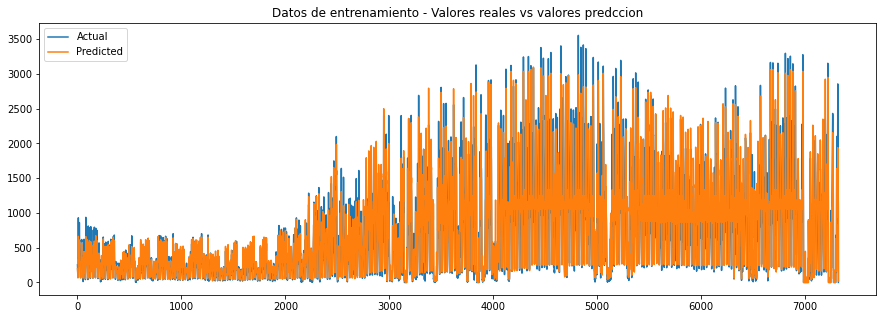

In [50]:
plt.figure(figsize=(15,5),facecolor=("white"))

plt.plot(y_train.reset_index(drop=True))
plt.plot(list(y_train_pred))
plt.title('Datos de entrenamiento - Valores reales vs valores predccion')
plt.legend(["Actual", "Predicted"])
plt.savefig('comparative_actual_model_train_set.png',orientation='landscape',bbox_inches='tight',transparent=False)

Y otra gráfica donde se observen los datos reales del conjunto de prueba contra los datos que se predijeron

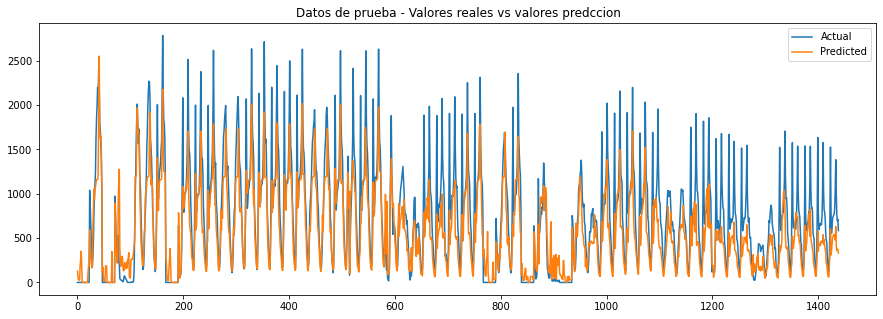

In [51]:
plt.figure(figsize=(15,5),facecolor=("white"))

plt.plot(y_test.reset_index(drop=True))
plt.plot(list(y_test_pred))
plt.title('Datos de prueba - Valores reales vs valores predccion')
plt.legend(["Actual", "Predicted"])
plt.savefig('comparative_actual_model_test_set.png',orientation='landscape',bbox_inches='tight',transparent=False)

### 3.13 Exportación del modelo
Usando la librería pickle vamos a exportar nuestro modelo, para que en ocasiones futuras podamos utilizarlo

In [188]:
#publicamos el modelo
import pickle
pickle.dump(pipeline_modelo_ganador, open('model_prediction_bikerpro.pkl', 'wb'))